### **LAB 2B**: Simulation Prep


The thermistor is also a nonlinear resistive sensor. The purpose of this section will be to show
the techniques of linearization and signal processing. In full disclosure, we could simply use a
half-bridge for the thermistor (and you might do this for your final project). So, know a priori
this signal processing for this section is inherently overkill.


-----

In [1207]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [1208]:
### VARIABLES ###
# the following variables may be altered for a different thermistor component

# BETA MODEL:
B = 3636
Ro = 1000 #ohm
To = 25 #deg C
To = To+273 #deg K

# STEINHART_HART MODEL:
# Must be evenly spaced & at least 10deg apart
# unit is deg.C

T1 = 10
T2 = 20
T3 = 30



#### **Deliverable 4b**: Model of Thermistor and Linearization

Before building the hardware, let’s model the sensor and use the power of code to make a
plethora of simulations. You can build these simulations in Excel, MATLAB (live script), Python
(Jupyter Notebooks), etc... There are three main ways to model a thermistor:

- Load the [thermistor datasheet](https://www.jameco.com/Jameco/Products/ProdDS/207483.pdf) and plot the data supplied
and fit a least-squares model.
- Use the Beta model provided in the slides and look on the datasheet to find the
corresponding parameters (note B is the same as Beta on this datasheet).
- Use the Steinhart-Hart model provided in the slides and harvest parameter values from
the datasheet.

**Create a labeled plot with all three models over the entire range of the sensor. Call this Figure 1.**

In [1209]:
### FIGURE 1 ###

In [1210]:
# Loading in thermistor datasheet values

temps = []
for i in range(-50,160,10):
    temps.append(i)

    if i == 20:
        temps.append(25) # this is an outlier in the pattern due to being nominal R

ohms = [44130, 23980, 13520, 7891, 4754, 2949, 1879, 1226, 1000, 819.4, 
        559.2, 389.3, 276, 199, 145.8, 108.4, 81.68, 62.35, 48.18, 37.64,
        29.72, 23.7]

In [1211]:
data = { "Temperature":temps , "Ohms":ohms }
df = pd.DataFrame(data=data)

df # display the table

,Temperature,Ohms
0,-50,44130.00
1,-40,23980.00
2,-30,13520.00
3,-20,7891.00
4,-10,4754.00
5,0,2949.00
6,10,1879.00
7,20,1226.00
8,25,1000.00
9,30,819.40


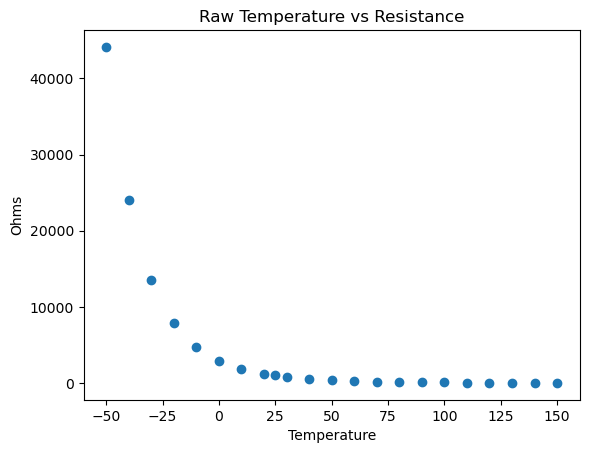

In [1212]:
# Plotting Temp vs Resistance to get a feel for the data

x = df['Temperature']
y = df['Ohms']

plt.scatter(x, y)

plt.xlabel('Temperature')
plt.ylabel('Ohms')
plt.title('Raw Temperature vs Resistance')

plt.show()

**First model**: [Linear Regression (least squares)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

In [1213]:
# Reshaping data to work w/ linreg model

X = x.to_numpy()
Y = y.to_numpy()

X = X.reshape((-1,1))
Y = Y.reshape((-1,1))

In [1214]:
# Splitting data into test and train
# Test size of 15% and random state of 42

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.15,random_state=42)

In [1215]:
# Linear Regression Model

linreg = LinearRegression()
linreg.fit(X_train, Y_train) # Fitting the model to the training data

LinearRegression()

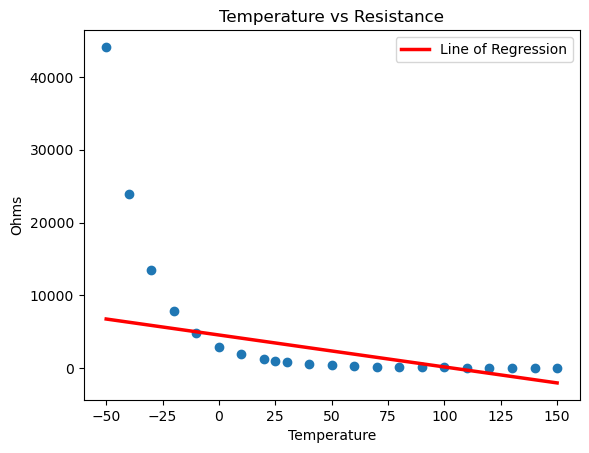

In [1216]:
### LINEAR REGRESSION PLOT ###

plt.scatter(x,y)
plt.plot(X,( linreg.intercept_ + X*linreg.coef_ ),c='r', label='Line of Regression', linewidth = '2.5')

plt.title("Temperature vs Resistance")
plt.xlabel('Temperature')
plt.ylabel('Ohms')

plt.legend()
plt.show()

In [1217]:
# Now using peicewise linearization 
# (same procress as above w/ two lines of regression)

# Splitting the data at 0 to provide two seperate linearization regions

matching_rows = df[df['Temperature'] == 0].index # Get the index of rows where temperature is 0

# Split the DataFrame
df1 = df.loc[:matching_rows[0]-1]  # Rows before the matching value
df2 = df.loc[matching_rows[0]:]    # Rows from the matching value onwards

# Initializing the two new pairs of split x/y values
x1 = df1['Temperature']
x2 = df2['Temperature']

y1 = df1['Ohms']
y2 = df2['Ohms']

# Reshaping data to work w/ linreg model
X1 = x1.to_numpy()
Y1 = y1.to_numpy()

X1 = X1.reshape((-1,1))
Y1 = Y1.reshape((-1,1))

X2 = x2.to_numpy()
Y2 = y2.to_numpy()

X2 = X2.reshape((-1,1))
Y2 = Y2.reshape((-1,1))

In [1218]:
# Splitting data into test and train
# Test size of 15% and random state of 42

# first set
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1,test_size=0.15,random_state=42)

# second set
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2,test_size=0.15,random_state=42)

In [1219]:
# Linear Regression Model(s)

linreg1 = LinearRegression()
linreg2 = LinearRegression()

linreg1.fit(X1_train, Y1_train) # Fitting the model to the training data
linreg2.fit(X2_train, Y2_train) # Fitting the model to the training data

LinearRegression()

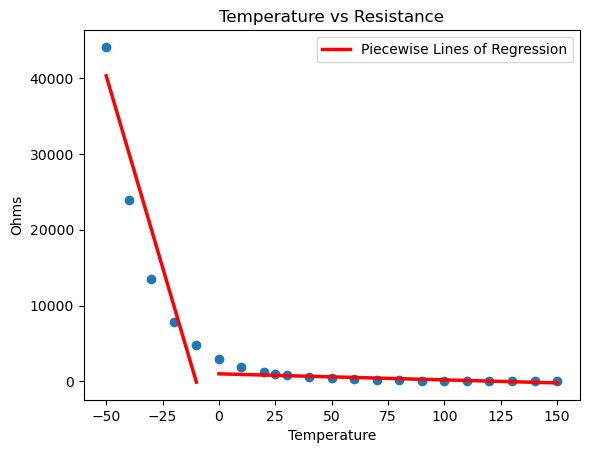

In [1220]:
### PIECEWISE LINEAR REGRESSION PLOT ###

plt.scatter(x,y) # scattering original data

plt.plot(X1,( linreg1.intercept_ + X1*linreg1.coef_ ),c='r', label='Piecewise Lines of Regression', linewidth = '2.5')
plt.plot(X2,( linreg2.intercept_ + X2*linreg2.coef_ ),c='r', linewidth = '2.5')

plt.title("Temperature vs Resistance")
plt.xlabel('Temperature')
plt.ylabel('Ohms')

plt.legend()
plt.show()

**Second model**: Beta model (from slides)

R(T) = Ro*e^( Beta( 1/T - 1/To ))

T = Beta / [ln(R(T) / Ro*e^(- Beta/To))]

<br>

From [thermistor datasheet](https://www.jameco.com/Jameco/Products/ProdDS/207483.pdf) :

- Beta (25 deg.C / 50 deg.C): 3636 +/- 2%
- Ro: 1 kohm
- To: 25 deg.C
- R(T): real time thermistor resistance

In [1221]:
model_ohms = []
for temp in temps:

    temp_K = temp+273 #deg K

    resistance = Ro*(math.e**(B*((1/temp_K) - (1/To))))
    model_ohms.append(resistance)

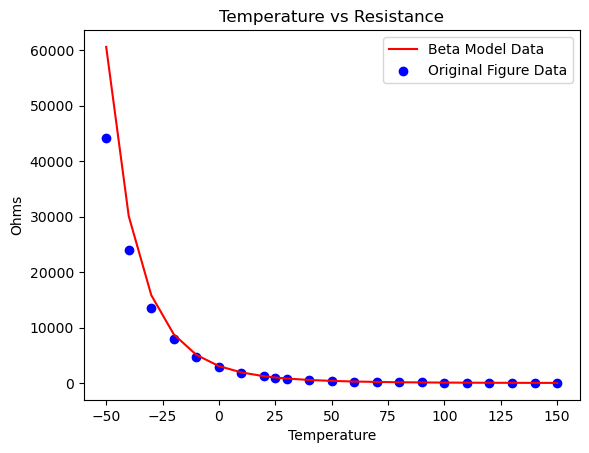

In [1222]:
### BETA MODEL PLOT ###

plt.plot(x, model_ohms, c='r', ls='-', label='Beta Model Data') # model data
plt.scatter(x, y, c='b', label='Original Figure Data') # original data

plt.xlabel('Temperature')
plt.ylabel('Ohms')
plt.title('Temperature vs Resistance')

plt.legend()
plt.show()

**Third model**: [Steinhart-Hart equation](https://www.ametherm.com/thermistor/ntc-thermistors-steinhart-and-hart-equation) (from slides)

R(T) = e^[ (x - y/2)^(1/3) - (x + y/2)^(1/3) ]
where:
- y = (a - 1/T)/c
- x = sqrt( (b/3c)^3 + (y^2/4) )

T = 1 / (a + b*ln(R) + cln^3(R) )

In [1223]:
# solving for constants A, B, C

t = [T1, T2, T3]
r = [ohms[temps.index(T1)], ohms[temps.index(T2)], ohms[temps.index(T3)]]

t_K = []
for temp in t:
    t_K.append(temp+273) # converting from deg.C -> K

L = []
for res in r:
    L.append(math.log(res)) # calculating for L1, L2, L3

Y = []
for temp in t_K:
    Y.append(1/temp) # calculating for Y1, Y2, Y3

y2 = (Y[1] - Y[0])/(L[1] - L[0]) # note: zero indexing!
                                 # (Y2-Y1) / (L2-L1)
y3 = (Y[2] - Y[0])/(L[2] - L[0]) # (Y3-Y1) / (L3-L1)

C = ( (y3-y2)/(L[2] - L[1]) )*((sum(L))**(-1))   # [ (y3-y2)/(L3-L2) ][ (L1+L2+L3)^-1 ]
B = ( y2 - C*( L[0]**2 + L[0]*L[1] + L[1]**2 ) ) # y2 - C( L1^2 + L1L2 + L2^2)
A = ( Y[0] - L[0]*( B + C*L[0]**2 ) )

print(f"A: {A}")
print(f"B: {B}")
print(f"C: {C}")

A: 0.0015329472399996345
B: 0.00025608247244766186
C: 1.6373599727735712e-07


In [1224]:
# Calculating temp for every datasheet resistance

model_temp = []
for r in ohms:
    temp_K = 1 / ( A + B*math.log(r) + C*((math.log(r))**3) )
    temp = temp_K - 273 #deg. C
    model_temp.append(temp)

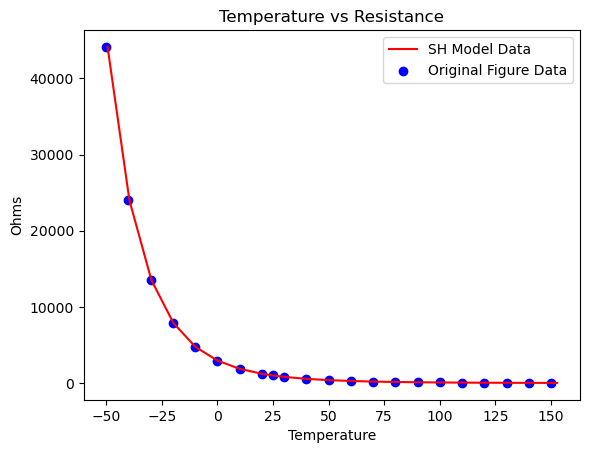

In [1225]:
### STEINHART-HART MODEL PLOT ###

plt.plot(model_temp, y, c='r', ls='-', label='SH Model Data') # model data
plt.scatter(x, y, c='b', label='Original Figure Data') # original data

plt.xlabel('Temperature')
plt.ylabel('Ohms')
plt.title('Temperature vs Resistance')

plt.legend()
plt.show()

<i>In my lab documentation, the multiple plots above have been compiled into Figure 1.</i>

Next, apply the materials in the lecture slides to linearize the sensor’s response. Write code so
this can be done generically as the following will ask you to change values.

- Use the 3-point method and linearize the sensor over a small region. Here small region
means +/- 10 degrees from room temperature. Assume room temp is 20 degrees Celsius.
Make a figure showing the nonlinear model over the small region AND the linearized
response.
- Use the ‘force-an-inflection-point’ method around room temperature to linearize the
sensor. Add this to your last plot.
- Use the 3-point method and linearize the sensor over the largest region you can solve for.
Note that a negative value of resistance means the range is too large. We will be using
passive components so <0 is our limit (But... negative resistance...
https://link.springer.com/content/pdf/10.1007/978-3-030-00740-9_3.pdf and
https://www.testandmeasurementtips.com/meaning-measurement-negative-resistance/
is quite interesting!) Make a new figure showing the nonlinear model over the region
and the linearized response.

**Create the two new Figures 2 and 3.**

In [1226]:
### FIGURE 2 ###

**Three Point Method**

T1 - T2  =  T2 - T3

Rp1-Rp2 = Rp2-Rp3

R = [RT2*(RT1+RT3) - 2* RT1 * RT3] / (RT1 + RT3 - 2*RT2)

<br>

Room temp = 20deg. C

We want +/- 10 degrees, therefore:
- T1 = 10
- T2 = 20
- T3 = 30

In [1227]:
three_temps = [T1,T2,T3] # this holds the rated temperatures
three_temps_R = []       # this holds the resistances corresponding to the temperatures
indicies = []            # this holds the indicies for these matched T & R pairs (for plotting og data)

for i, temp in enumerate(three_temps):
    place = temps.index(temp)

    indicies.append(place)
    three_temps_R.append(ohms[place])

three_temps, three_temps_R, indicies

([10, 20, 30], [1879, 1226, 819.4], [6, 7, 9])

In [1228]:
from scipy.stats import linregress

# getting slope & intercept by fitting line parameters to the three points 
# (using a linear regression function to save the effort)
slope, intercept, _, _, _ = linregress(three_temps, three_temps_R) 

three_R = []
for i in range(3):
    three_R.append(intercept + (slope*three_temps[i])) # new R points to plot

In [1229]:
R = ( three_temps_R[1]*(three_temps_R[0]+three_temps_R[2]) - 2*three_temps_R[0]*three_temps_R[2] ) / ( three_temps_R[0]+three_temps_R[2]-(2*three_temps_R[1]) )

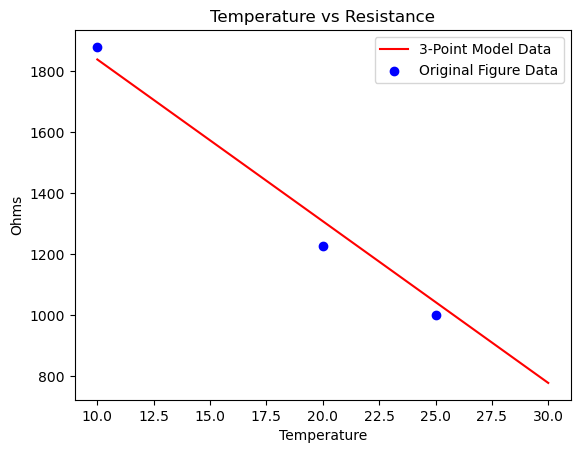

R = 929.1120129870134


In [1230]:
### THREE TEMP MODEL PLOT ###

plt.plot(three_temps, three_R, c='r', ls='-', label='3-Point Model Data') # model data
plt.scatter(x[indicies[0]:indicies[2]], y[indicies[0]:indicies[2]], c='b', label='Original Figure Data') # original data

plt.xlabel('Temperature')
plt.ylabel('Ohms')
plt.title('Temperature vs Resistance')

plt.legend()
plt.show()

print(f"R = {R}")

**Force an Inflection Method**

We want to find the slope at the point of 20deg. C.

In [1231]:
T_room = 20

i = temps.index(20)
R_room = ohms[i]

R_room

1226

In [1232]:
# calculating the slope at 20deg. C using neighboring points 

slope = (ohms[i+1] - ohms[i-1]) / (temps[i+1] - temps[i-1])

''' Below is from Perplexity '''
# Create a linear equation using the slope and R_20
R_20 = ohms[i]
linear_eq = lambda t: slope * (t - 20) + R_20

# Generate points for the linear equation
t_linear = np.linspace(min(temps), max(temps), 100)
R_linear = linear_eq(t_linear)
''' end '''

' end '

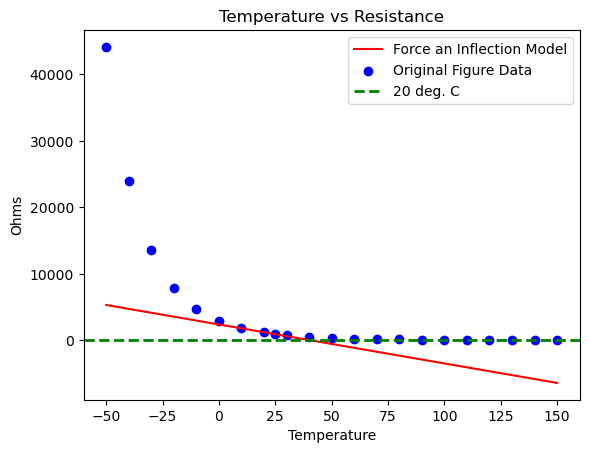

In [1233]:
### FORCE AN INFLECTION PLOT ###

plt.plot(t_linear, R_linear, c='r', ls='-', label='Force an Inflection Model') # model data
plt.scatter(x, y, c='b', label='Original Figure Data') # original data

plt.axhline(20, color='green', linestyle='--', linewidth=2, label='20 deg. C')

plt.xlabel('Temperature')
plt.ylabel('Ohms')
plt.title('Temperature vs Resistance')

plt.legend()
plt.show()

In [1234]:
### FIGURE 3 ###

I am going to create a loop that adds a temperature at location i-1, then i+1 from 20 degrees until the R calculation no longer is positive.

In [1235]:
temp_range = [three_temps[1]]        # this will hold the determined range of temps (starting with 20deg. C)
R_range = [three_temps_R[1]]             # this holds the resistances corresponding to the temperatures
indicies = [temps.index(three_temps[1])]            # this holds the indicies for these matched T & R pairs (for plotting og data)

# starting indicies for the loop
start_place_up = indicies[0]
start_place_down = indicies[0]

for i in range(len(temps)-1):    # looping through until the entire range of temps has been traversed
                                 # one number is subtracted to account for the starting point temp (20deg. C)
                                 # (although it most definetly will turn negative before then)

    if i>3:
        index1 = R_range[0]
        index2 = R_range[len(R_range)//2]
        index3 = R_range[-1]

        R_solve = ( index2*(index1+index3) - 2*index1*index3 ) / ( index1+index3-(2*index2) )

        if R_solve <= 0:
            print(f"R: {R_solve}, breaking loop...")
            break
        else:
            R = R_solve
            print(f"R: {R}")

    # alternating adding indicies from above and below with odd/even:

    if (i % 2) == 0: # even
        start_place_up += 1
        temp_range.append(temps[start_place_up])
        R_range.append(ohms[start_place_up])
        indicies.append(start_place_up)
    
    else: # odd
        start_place_down -= 1
        temp_range.append(temps[start_place_down])
        R_range.append(ohms[start_place_down])
        indicies.append(start_place_down)

temp_range.sort() # put into numerical order
R_range.sort(reverse=True) # non-linear, but should still decrease with temp (inverse log)
indicies.sort()

temp_range, R_range, indicies


R: 1472.1270983213428
R: 625.9185792349706
R: -1556.435087072699, breaking loop...


([-10, 0, 10, 20, 25, 30, 40],
 [4754, 2949, 1879, 1226, 1000, 819.4, 559.2],
 [4, 5, 6, 7, 8, 9, 10])

In [1236]:
from scipy.stats import linregress

# getting slope & intercept by fitting line parameters to the three points 
# (using a linear regression function to save the effort)
slope, intercept, _, _, _ = linregress(three_temps, three_temps_R) 

R_range_plot = []
for i in range(len(R_range)):
    R_range_plot.append(intercept + (slope*temp_range[i])) # new R points to plot

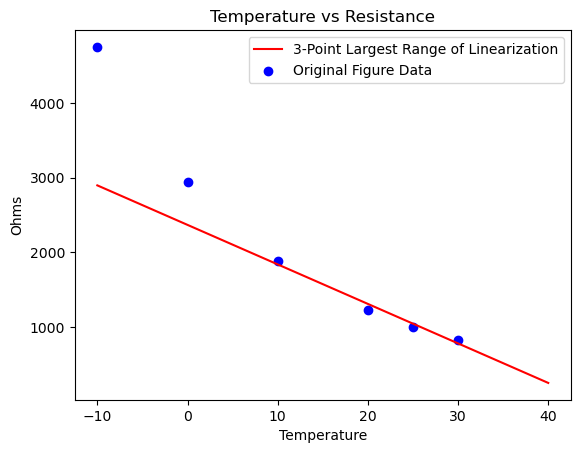

R = 625.9185792349706


In [1237]:
### THREE POINT MODEL LARGE RANGE PLOT ###

plt.plot(temp_range, R_range_plot, c='r', ls='-', label='3-Point Largest Range of Linearization') # model data
plt.scatter(x[indicies[0]:indicies[-1]], y[indicies[0]:indicies[-1]], c='b', label='Original Figure Data') # original data

plt.xlabel('Temperature')
plt.ylabel('Ohms')
plt.title('Temperature vs Resistance')

plt.legend()
plt.show()

print(f"R = {R}")

Analyze the figures, did you notice the trends that the smaller the region the better the
linearization? Hopefully you wrote your code so that you can easily change the regions. Main
conclusion: With 1 simple resistor in series, you can make the response linear in a region. So, if
you grabbed any resistor (with doing no math) and put it in parallel, it would linearize the
response. However, in doing the math to calculate the value of resistance you ensure the
response is most linear in the region of interest.

**Let’s suppose our sensor is now a capacitor (instead of a resistor). This capacitive sensor has a
nonlinear response. Give a circuit to linearize it.**

One of the downsides of linearization is since we flatten out the response, we lose dynamic range
of the sensor. The pro is that the sensitivity goes nearly constant, but since the response is
flattened, we often need to amplify.